# Imports

In [3]:
# synth image link: https://www.kaggle.com/datasets/ilya9711nov/isic-2024-synthetic/data?select=images

In [2]:
# === Install dependencies if needed (uncomment if running outside Kaggle) ===
# !pip install timm==1.0.9
# !pip install albumentations==1.4.14
# !pip install torcheval==0.0.7
# !pip install pandas==2.2.2
# !pip install numpy==1.26.4

# === Imports ===
import sys, os, time, copy, gc
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import multiprocessing as mp

from torcheval.metrics.functional import binary_auroc, multiclass_auroc
from sklearn.model_selection import StratifiedGroupKFold, train_test_split

import hashlib
from joblib import Parallel, delayed
import torch.optim as optim
from collections import defaultdict

# === Add local project source folder ===
sys.path.append('../src')

# === Custom Project Modules (must exist in ../src) ===
from utils import set_seed, visualize_augmentations_positive, print_trainable_parameters
from models import ISICModel, ISICModelEdgnet, setup_model
from training import fetch_scheduler, train_one_epoch, valid_one_epoch, run_training, get_nth_test_step
from datasets import ISICDatasetSamplerW, ISICDatasetSampler, ISICDatasetSimple, ISICDatasetSamplerMulticlass, prepare_loaders
from augmentations import get_augmentations

# === Check Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")


Using device: cuda
GPU: NVIDIA GeForce RTX 3090 Ti
Number of GPUs: 1


# Configuration Dictionary

In [ ]:
CFG = {
    "seed": 42,
    "img_size": 512,
    "model_name": "convnextv2_base.fcmae_ft_in22k_in1k_384",  # or use eva02_small_patch14_224
    "epochs": 10,
    "train_bs": 8,
    "valid_bs": 16,
    "lr": 1e-4,
    "num_workers": 4,
    "folds": 5,
    "patience": 3,
    "weights": "imagenet",  # pretrained weights
    "target_cols": ["target"],
    "device": device,
    "task": "binary",  # classification task
    "scheduler": "CosineAnnealingLR",
    "T_max": 10,
    "min_lr": 1e-6,
    "wd": 1e-6,
    "n_accumulate": 1,
    "verbose": True,
}


# Load and Preprocess Metadata

In [ ]:
# === Load Metadata ===
metadata_path = "../input/train-metadata.csv"
df = pd.read_csv(metadata_path)

# === Create Full Image Path ===
df["image_path"] = df["isic_id"].apply(lambda x: f"../input/train-images/{x}.jpg")

# === Quick Check ===
print("Total samples:", len(df))
print("Target distribution:\n", df["target"].value_counts())
df.head()

# Create Stratified Group K-Folds

In [ ]:
# === Add Fold Column ===
df["fold"] = -1

# === Stratified Group K-Fold Split ===
skf = StratifiedGroupKFold(
    n_splits=CFG["folds"],
    shuffle=True,
    random_state=CFG["seed"]
)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["target"], groups=df["patient_id"])):
    df.loc[val_idx, "fold"] = fold

# === Show Fold Distribution ===
print("Fold distribution:")
print(df["fold"].value_counts())


# Set Random Seed

In [ ]:
# === Set Seed for Reproducibility ===
set_seed(CFG["seed"])

# Augmentation Setup

In [ ]:
# === Get Train & Validation Augmentations ===
data_transforms = get_augmentations(
    img_size=CFG["img_size"]
)

# Example access:
# data_transforms["train"] -> Training augmentations
# data_transforms["valid"] -> Validation augmentations

# Dataset & DataLoader Setup

In [ ]:
# === Choose Fold to Train (for example: fold 0) ===
FOLD = 0

# === Split Train and Validation Data ===
df_train = df[df["fold"] != FOLD].reset_index(drop=True)
df_valid = df[df["fold"] == FOLD].reset_index(drop=True)

# === Prepare DataLoaders using custom utility ===
train_loader, valid_loader = prepare_loaders(
    df_train=df_train,
    df_valid=df_valid,
    CFG=CFG,
    transforms=data_transforms
)

# === Quick Check ===
print("Train batches:", len(train_loader))
print("Valid batches:", len(valid_loader))

# Model Setup

In [ ]:
# === Build the Model ===
model = setup_model(
    model_name=CFG["model_name"],
    task=CFG["task"],            # 'binary' or 'multiclass'
    pretrained=True,
    num_classes=len(CFG["target_cols"]),
    img_size=CFG["img_size"]
)

# === Move to Device ===
model.to(CFG["device"])

# === Print Parameter Summary ===
print_trainable_parameters(model)


# Loss Function & Metrics

In [ ]:
from torcheval.metrics.functional import binary_auroc

# === Loss Function ===
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

# === Metric Function ===
metric_function = binary_auroc

# Training and Validation Setup

In [ ]:
# === Optimizer ===
optimizer = optim.Adam(
    model.parameters(),
    lr=CFG["lr"],
    weight_decay=CFG["wd"]
)

# === Scheduler ===
scheduler = fetch_scheduler(optimizer, CFG)

# === Run Full Training Loop ===
model, history = run_training(
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    device=CFG["device"],
    num_epochs=CFG["epochs"],
    CONFIG=CFG,
    tolerance_max=20,
    test_every_nth_step=lambda x: 5,
    seed=CFG["seed"]
)


# Save Model & OOF Predictions

In [ ]:
# === Save Model Weights ===
model_save_path = f"model_fold{FOLD}.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [ ]:
# === Optional: Re-evaluate to Get OOF Predictions ===
val_loss, val_auc, _, val_preds, val_targets = valid_one_epoch(
    model=model,
    valid_loader=valid_loader,
    device=CFG["device"],
    epoch=0,
    optimizer=optimizer,
    criterion=criterion,
    use_custom_score=True,
    metric_function=metric_function,
    num_classes=1,
    return_preds=True
)

# === Attach Predictions to Fold Data ===
df_oof = df_valid.copy()
df_oof["pred"] = val_preds
df_oof["true"] = val_targets

# === Save OOF Predictions ===
oof_save_path = f"oof_predictions_fold{FOLD}.csv"
df_oof.to_csv(oof_save_path, index=False)
print(f"OOF predictions saved to {oof_save_path}")


# Multi-Fold Training Loop & Final OOF Assembly

In [ ]:
# === Store OOF Predictions for All Folds ===
all_oof = []

# === Loop Through Each Fold ===
for FOLD in range(CFG["folds"]):
    print(f"\n=== Fold: {FOLD} ===")

    # --- Split Data ---
    df_train = df[df["fold"] != FOLD].reset_index(drop=True)
    df_valid = df[df["fold"] == FOLD].reset_index(drop=True)

    # --- Data Loaders ---
    train_loader, valid_loader = prepare_loaders(
        df_train=df_train,
        df_valid=df_valid,
        CFG=CFG,
        transforms=data_transforms
    )

    # --- Model ---
    model = setup_model(
        model_name=CFG["model_name"],
        num_classes=len(CFG["target_cols"]),
        pretrained=True,
        task=CFG["task"]
    )
    model.to(CFG["device"])
    print_trainable_parameters(model)

    # --- Optimizer & Scheduler ---
    optimizer = optim.Adam(model.parameters(), lr=CFG["lr"], weight_decay=CFG["wd"])
    scheduler = fetch_scheduler(optimizer, CFG)

    # --- Train ---
    model, history = run_training(
        train_loader=train_loader,
        valid_loader=valid_loader,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        device=CFG["device"],
        num_epochs=CFG["epochs"],
        CONFIG=CFG,
        tolerance_max=20,
        test_every_nth_step=lambda x: 5,
        seed=CFG["seed"]
    )

    # --- Save Model ---
    model_save_path = f"model_fold{FOLD}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # --- Get OOF Predictions ---
    _, _, _, preds, targets = valid_one_epoch(
        model=model,
        valid_loader=valid_loader,
        device=CFG["device"],
        epoch=0,
        optimizer=optimizer,
        criterion=criterion,
        use_custom_score=True,
        metric_function=metric_function,
        num_classes=1,
        return_preds=True
    )

    df_fold_oof = df_valid.copy()
    df_fold_oof["pred"] = preds
    df_fold_oof["true"] = targets
    df_fold_oof["fold"] = FOLD

    all_oof.append(df_fold_oof)


In [ ]:
# === Combine and Save OOF Predictions Across All Folds ===
df_all_oof = pd.concat(all_oof).reset_index(drop=True)
df_all_oof.to_csv("oof_predictions_all_folds.csv", index=False)
print("Saved full OOF predictions to oof_predictions_all_folds.csv")

# MISC

✅ What's Already Covered in Your CNN Training Code:

Your notebook already implements these key elements from the 1st place solution:
- EVA02 and EdgeNeXt models	✅	Defined in setup_model() and trained via run_training()
- 5-fold Stratified Group K-Fold	✅	Done using patient_id and target
- AUROC metric	✅	Uses torcheval.binary_auroc
- Early stopping	✅	Controlled via patience in run_training()
- CNN predictions used in GBDT	✅ (planned)	Your ensemble plan includes this
- Save OOF predictions	✅	Written in step 11 & 12
- Use of Albumentations	✅	Handled in get_augmentations()
- Pretrained models via timm	✅	Used in setup_model()
- Class-balanced batch sampling	✅ Handled	Your ISICDatasetSampler and ISICDatasetSamplerW enforce balanced sampling of 1:1 malignant:benign per batch.
- Validation schedule optimization	✅ Handled	Your run_training() uses a dynamic validator (get_nth_test_step()), validating less often in early epochs, more frequently later — just like the winner.

❌ What's Missing or Partially handled Compared to the 1st Place Solution
- Synthetic data usage	⚠️ Partially	The dataset/sampler supports it, but your training notebook does not yet load or merge synthetic data (e.g., from SD 1.5).
- Multiple seeds / repeated CV	⚠️ Optional	Your code currently runs one seed per fold. You’d need to wrap the full 5-fold CV in a loop over n_seeds.
- Standardization of CNN outputs before GBDT	❌ Not Handled	OOF predictions are saved, but there’s no normalization + noise injection (σ=0.1) before passing to GBDT models.
- Pretraining on multi-class external data	❌ Not Handled	Your pipeline only supports binary labels (target). There’s no multi-class model trained on external data (diagnosis_pr) and merged.
- Integration of predictions across multiple epochs	❌ Not Handled	Only the best model (based on validation) is saved. There is no saving at epoch 40, 45, 50 or ensembling of multiple epochs.

The 1st-place team **trained a 3-class CNN model** with labels:

- **nevus**
- **melanoma**
- **bkl** (basal cell carcinoma-like lesions: SK, lentigo, etc.)

This wasn’t used directly for classification in the final evaluation — instead, it served a very **clever auxiliary role** in the pipeline.

---

## 🎯 Why Train a 3-Class Model?

### ✅ 1. **Leverage Richer Diagnostic Labels**
Instead of just binary `target` (benign vs malignant), the external datasets (like ISIC 2020/21) often provide more granular labels under `diagnosis` or `diagnosis_pr`:
- `melanoma` (malignant)
- `nevus` (benign)
- `seborrheic keratosis`, `solar lentigo`, etc. (grouped as bkl)

Using these as **supervised labels**, you can:
- Train a better feature extractor
- Capture **disease-specific representations** (more informative than binary)

---

### ✅ 2. **Generate Additional Features for Tabular Model**

Once trained, they used the **output probabilities** from this 3-class CNN as **new tabular features**:
- `p_nevus`
- `p_melanoma`
- `p_bkl`

These features were:
- **Patient-specific lesion-level insights**
- **Highly predictive** for the downstream GBDT model

---

### ✅ 3. **Handle Ambiguity + Edge Cases Better**

Binary `target` is noisy:
- Some benign lesions look suspicious (false positives)
- Some malignant ones are subtle (false negatives)

The 3-class model helps disentangle this by:
- Providing **soft confidence per diagnosis**
- Giving the GBDT model richer context (e.g., “this lesion looks like melanoma but model is unsure”)

---

## 🧠 Analogy

Think of it like using a **specialist AI dermatologist** (the 3-class CNN) to give a second opinion — then combining that opinion with the original clinical metadata for the final judgment.

---

## 📈 Did It Help?

Yes — according to the winner’s notes:
> “… adding the predictions from this model to the models based only on tabular data **significantly improved** both the CV and leaderboard scores.”

---

## ✅ Summary: Why Train a 3-Class CNN

| Reason                           | Benefit                                           |
|----------------------------------|---------------------------------------------------|
| More informative labels          | Better feature representation than just binary   |
| Additional tabular features      | Predictive soft labels (`p_nevus`, etc.)         |
| Handles label noise              | Captures uncertainty instead of forcing hard 0/1 |
| Improved final ensemble          | Helped the GBDT model generalize better          |

---


### 🔁 **Original Mapping** (5-class → MEL, BCC, SCC, NV)

```text
2019 MEL, BCC, SCC, NV                   → MEL, BCC, SCC, NV  
2020 melanoma                            → MEL  
2020 nevus                               → NV  
PAD UFES 20 MEL, BCC, SCC, NEV           → MEL, BCC, SCC, NV  
2024 Basal cell carcinoma (iddx_full)    → BCC  
2024 Melanoma (iddx_full)                → MEL  
2024 Squamous cell carcinoma (iddx_full) → SCC  
2024 Nevus (iddx_full)                   → NV
```

---

### ✅ **Converted Mapping (3-class → `melanoma`, `nevus`, `bkl`)**

| Dataset | Original Diagnosis | → 3-Class Label |
|---------|---------------------|-----------------|
| **2019** | MEL                | melanoma        |
|         | BCC                | bkl             |
|         | SCC                | bkl             |
|         | NV                 | nevus           |
| **2020** | melanoma           | melanoma        |
|         | nevus              | nevus           |
| **PAD-UFES-20** | MEL        | melanoma        |
|                | BCC        | bkl             |
|                | SCC        | bkl             |
|                | NEV        | nevus           |
| **2024 (iddx_full)** | Basal cell carcinoma  | bkl        |
|                      | Melanoma              | melanoma   |
|                      | Squamous cell carcinoma | bkl      |
|                      | Nevus                 | nevus      |

---

### 📌 Summary Mapping Function

| Class (Grouped) | Contains Diagnoses |
|------------------|---------------------|
| `melanoma`       | MEL / melanoma       |
| `nevus`          | NV / nevus           |
| `bkl`            | BCC, SCC, SK, solar lentigo, lentigo NOS, etc. |

---

## ✅ Do You Average the Outputs from All 150 Models?

**Yes — but with some important steps and nuances.**

---

## ✅ Step-by-Step Explanation

### 1️⃣ **150 Models Total**:
- 3 GBDT types × 5 folds × 10 seeds = **150 models**
  - **CatBoost**
  - **LightGBM (LGBM)**
  - **XGBoost**

### 2️⃣ **Each model makes predictions on the validation/test set**

For every fold and seed:
- Get out-of-fold (OOF) predictions on validation data
- Get test predictions

---

### 3️⃣ **Standardize Each Model’s Predictions**
Before combining:
- Apply **z-score normalization** to each model’s prediction vector **independently**
```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_preds = scaler.fit_transform(model_preds.reshape(-1, 1)).flatten()
```

- Optionally, add **Gaussian noise** (e.g., `np.random.normal(0, 0.1, size=...)`) to simulate robustness

---

### 4️⃣ **Rank and Percentile Transform (Optional)**
Some models used:
```python
ranked = pd.Series(preds).rank(pct=True)
```
→ To stabilize ensemble behavior across outliers.

---

### 5️⃣ **Average Across Models (Equal Weight)**
Once all predictions are standardized (and possibly ranked), **average them with equal weight**:
```python
ensemble_preds = np.mean([
    standardized_catboost_preds,
    standardized_lgbm_preds,
    standardized_xgb_preds,
    ...
], axis=0)
```

You can average:
- Per fold
- Per seed
- Per model type (and then across model types)

---

## ✅ Summary of Your Question

| Step                              | Do you do it? | Details |
|-----------------------------------|---------------|---------|
| Train 150 models                  | ✅            | 5 folds × 10 seeds × 3 models |
| Average all model predictions     | ✅            | After standardization |
| Standardize predictions           | ✅            | Z-score independently |
| Add noise during training         | ✅            | Gaussian noise, σ = 0.1 |
| Use prediction-to-patient-mean ratio | ✅        | Improves performance |
| Use `.rank(pct=True)` (optional)  | ✅/⚠️         | Useful to mitigate scale differences |

---

In [3]:
# SkinSAM Inference Notebook
# 1. Setup Environment
# !pip install -q opencv-python matplotlib
# !pip install -q transformers accelerate timm

# Step 2: Load SkinSAM from Hugging Face
from transformers import SamModel, SamProcessor
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

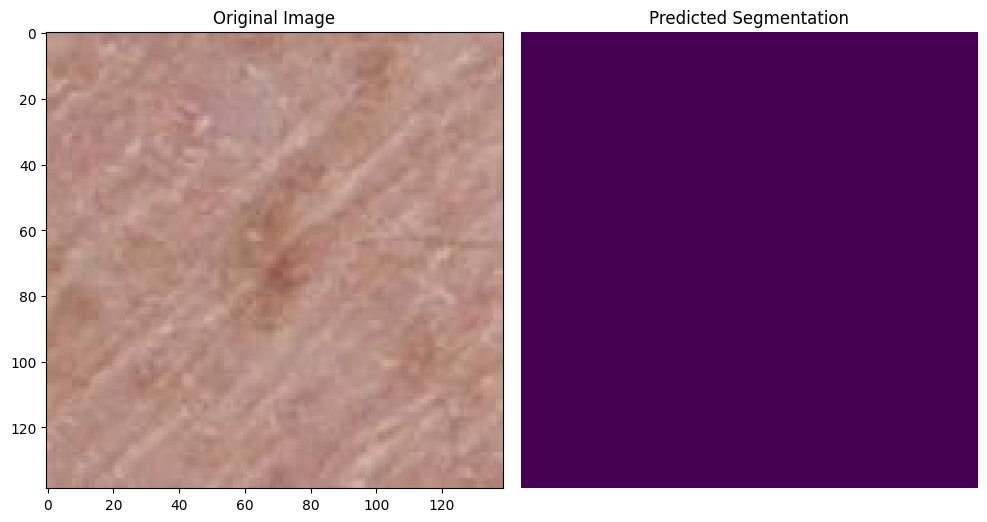

In [ ]:
# Step 3: Load model and processor
model_id = "ahishamm/skinsam"

processor = SamProcessor.from_pretrained(model_id)
model = SamModel.from_pretrained(model_id).to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Step 4: Load Your Image (uploaded as 'image.png')
image = Image.open("./train-image/image/ISIC_0015902.jpg").convert("RGB")

# Step 5: Provide a prompt (e.g. a point on the lesion area)
# You can adjust the point according to your image
input_points = [[[200, 200]]]  # (y,x) format
input_labels = [[1]]           # 1 means foreground

# Step 6: Preprocess input
inputs = processor(
    image,
    input_points=input_points,
    input_labels=input_labels,
    return_tensors="pt"
).to(model.device)

# Step 7: Predict the mask
with torch.no_grad():
    outputs = model(**inputs)
    masks = processor.post_process_masks(
        outputs.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu()
    )

# Step 8: Visualize
# Fix the shape issue (extract single channel)
mask = masks[0][0].numpy()[0]  # Now shape is (H, W)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
# plt.imshow(image)
plt.imshow(mask)
# plt.imshow(mask, alpha=0.5, cmap="jet")  # Overlay mask
plt.title("Predicted Segmentation")
plt.axis("off")
plt.tight_layout()
plt.show()


In [1]:
# !pip install keras

import numpy as np
import matplotlib.pyplot as plt
import cv2
import models as M

## BCDU_net_D3

1/1 [==============================] - 1s 780ms/step


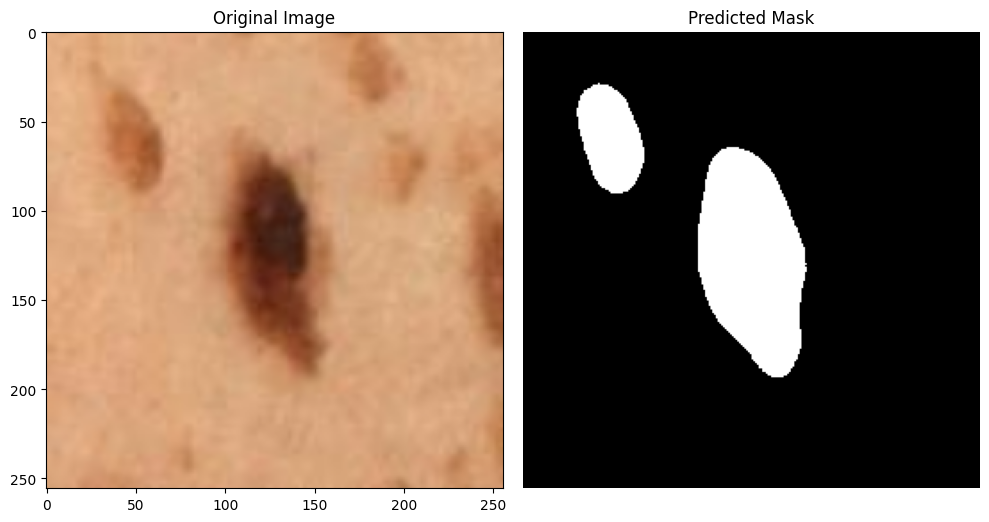

In [5]:
# ==== 1. Load and preprocess a single image ====

# Replace this with your image path
img_path = './train-image/image/ISIC_0082644.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (256, 256))  # Resize as expected by the model
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype(np.float32)

# Normalize like dataset_normalized
img_mean = np.mean(img)
img_std = np.std(img)
img_norm = (img - img_mean) / img_std
img_norm = ((img_norm - np.min(img_norm)) / (np.max(img_norm) - np.min(img_norm))) * 255

# Shape: (1, 256, 256, 3)
input_img = np.expand_dims(img_norm, axis=0)

# ==== 2. Load the model and weights ====
model = M.BCDU_net_D3(input_size=(256, 256, 3))
model.load_weights('./weights/weight_isic18.hdf5')

# ==== 3. Predict ====
prediction = model.predict(input_img)
pred_mask = prediction[0]  # shape: (256, 256, 1)

# Thresholding
pred_mask = np.where(pred_mask > 0.5, 1, 0)

# ==== 4. Show original + predicted mask ====
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.astype(np.uint8))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.savefig('single_prediction_result.png')
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import tensorflow as tf
import models as M

# === CONFIG ===
input_dir = './train-image/image'
output_dir = './train-image/masks_pred'
os.makedirs(output_dir, exist_ok=True)
batch_size = 256
input_size = (256, 256)

# === ENABLE TF GPU MEMORY GROWTH ===
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         print(f"Enabled memory growth for {len(gpus)} GPU(s).")
#     except RuntimeError as e:
#         print(f"Memory growth error: {e}")

# === LOAD MODEL ===
model = M.BCDU_net_D3(input_size=(*input_size, 3))
model.load_weights('./weights/weight_isic18.hdf5')

# === IMAGE LIST ===
image_files = [
    f for f in os.listdir(input_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# === Preprocessing Function ===
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Failed to load {img_path}")
        return None, os.path.basename(img_path)

    img = cv2.resize(img, input_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)

    img_mean, img_std = np.mean(img), np.std(img)
    img_norm = (img - img_mean) / img_std
    img_norm = ((img_norm - np.min(img_norm)) / (np.max(img_norm) - np.min(img_norm))) * 255

    return img_norm, os.path.basename(img_path)

# === Postprocessing Function ===
def save_mask(mask, img_name):
    pred_mask = (mask > 0.5).astype(np.uint8).squeeze() * 255
    mask_filename = os.path.splitext(img_name)[0] + '.png'
    mask_path = os.path.join(output_dir, mask_filename)
    cv2.imwrite(mask_path, pred_mask)

# === Process in Batches with TQDM ===
for i in tqdm(range(0, len(image_files), batch_size), desc="Processing Batches"):
    batch_files = image_files[i:i+batch_size]
    batch_paths = [os.path.join(input_dir, f) for f in batch_files]

    # Preprocess
    batch_data = [preprocess_image(p) for p in batch_paths]
    batch_data = [b for b in batch_data if b[0] is not None]

    if not batch_data:
        continue

    imgs, names = zip(*batch_data)
    input_batch = np.array(imgs)

    # Predict
    preds = model.predict(input_batch, verbose=0)

    # Save in parallel
    with ThreadPoolExecutor() as executor:
        executor.map(save_mask, preds, names)

In [ ]:
import sys, os, time, copy, gc
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path

import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import multiprocessing as mp

from torcheval.metrics.functional import binary_auroc, multiclass_auroc

from sklearn.model_selection import StratifiedGroupKFold

import hashlib
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split

from PIL import Image
import torch.optim as optim

from collections import defaultdict


sys.path.append('../src')
from utils import set_seed, visualize_augmentations_positive, print_trainable_parameters
from models import setup_model
from training import fetch_scheduler, train_one_epoch, valid_one_epoch, run_training, get_nth_test_step
from models import ISICModel, ISICModelEdgnet, setup_model
from datasets import ISICDatasetSamplerW, ISICDatasetSampler, ISICDatasetSimple, ISICDatasetSamplerMulticlass, prepare_loaders
from augmentations import get_augmentations

# Set up device and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")



original_data_path = "../data/original"
original_root = Path('../data/original')

data_artifacts = "../data/artifacts"
os.makedirs(data_artifacts, exist_ok=True)

# Set the HDF5 file path
TRAIN_HDF5_FILE_PATH = original_root / 'train-image.hdf5'

train_path = original_root / 'train-metadata.csv'
df_train = pd.read_csv(train_path)
df_train["path"] = '../data/original/train-image/image/' + df_train['isic_id'] + ".jpg"
original_positive_cases = df_train['target'].sum()
original_total_cases = len(df_train)
original_positive_ratio = original_positive_cases / original_total_cases

print(f"Number of positive cases: {original_positive_cases}")
print(f"Number of negative cases: {original_total_cases - original_positive_cases}")
print(f"Ratio of negative to positive cases: {(original_total_cases - original_positive_cases) / original_positive_cases:.2f}:1")

MODEL_NAME = "EVA" # "EDGENEXT"


CONFIG = {
    "seed": 42 if MODEL_NAME == 'EVA' else 1997,
    "epochs": 500,
    "img_size": 336 if MODEL_NAME == 'EVA' else 256,
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 2000,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "group_col": 'patient_id',
    "device": device
}

model_name = "eva02_small_patch14_336.mim_in22k_ft_in1k" if MODEL_NAME == 'EVA' else "edgenext_base.in21k_ft_in1k"
checkpoint_path = None


if MODEL_NAME == 'EVA':
    ISICModelPrep = ISICModel
else:
    ISICModelPrep = ISICModelEdgnet

data_transforms = get_augmentations(CONFIG)



def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

folder_name = f"../models/oof_{{MODEL_NAME.lower()}}_base"
os.makedirs(folder_name, exist_ok=True)

def get_metrics(drop_path_rate, drop_rate, models_folder, model_maker):
    tsp = StratifiedGroupKFold(5, shuffle=True, random_state=CONFIG['seed'])
    results_list = []
    fold_df_valid_list = []
    for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[CONFIG["group_col"]])):
        fold_df_train = df_train.iloc[train_index].reset_index(drop=True)
        fold_df_valid = df_train.iloc[val_index].reset_index(drop=True)
        set_seed(CONFIG['seed'])
        model = setup_model(model_name, drop_path_rate=drop_path_rate, drop_rate=drop_rate, model_maker=model_maker)
        print_trainable_parameters(model)

        train_loader, valid_loader = prepare_loaders(fold_df_train, fold_df_valid, CONFIG, data_transforms)
    
        optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
        scheduler = fetch_scheduler(optimizer, CONFIG)
    
        model, history = run_training(
            train_loader, valid_loader,
            model, optimizer, scheduler,
            device=CONFIG['device'],
            num_epochs=CONFIG['epochs'],
            CONFIG=CONFIG, 
            tolerance_max=20,
            test_every_nth_step=lambda x: 5,
            seed=CONFIG['seed'])
        torch.save(model.state_dict(), os.path.join(models_folder, f"model__{fold_n}"))
        results_list.append(np.max(history['Valid Kaggle metric']))

        val_epoch_loss, val_epoch_auroc, val_epoch_custom_metric, tmp_predictions_all, tmp_targets_all = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=1, 
            optimizer=optimizer, 
            criterion=criterion, 
            use_custom_score=True,
            metric_function=binary_auroc, 
            num_classes=1,
            return_preds=True)

        fold_df_valid['tmp_targets_all'] = tmp_targets_all
        fold_df_valid['tmp_predictions_all'] = tmp_predictions_all
        fold_df_valid['fold_n'] = fold_n
        fold_df_valid_list.append(fold_df_valid)
    fold_df_valid_list = pd.concat(fold_df_valid_list).reset_index(drop=True)
    return results_list, fold_df_valid_list

base_metrics, oof_forecasts = get_metrics(drop_path_rate=0, drop_rate=0, models_folder=folder_name, model_maker=ISICModelPrep)
oof_forecasts.to_parquet(f'../data/artifacts/oof_forecasts_{MODEL_NAME.lower()}_base.parquet')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import timm
import random
import matplotlib.pyplot as plt

# Import GradCAM components from pytorch_grad_cam package
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

#############################################
# Define a Decoder Block for the UNet decoder
#############################################
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        """
        in_channels : number of channels from the previous decoder block
        skip_channels : number of channels from the skip connection (encoder)
        out_channels : desired output channels for this block
        """
        super(DecoderBlock, self).__init__()
        # Transposed convolution upsamples the input feature map.
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # Concat (upsampled + skip) then two convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.up(x)
        # Concatenate along the channel dimension
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

#############################################
# Define the EVA02_Unet Model
#############################################
class EVA02_Unet(nn.Module):
    def __init__(self, config):
        """
        config: a dictionary with hyperparameters.
          Required keys:
           - 'model_name': str, e.g. 'eva02_small_patch16_224'
           - 'pretrained': bool
           - 'num_seg_classes': int, number of segmentation classes (use 1 for binary segmentation)
        """
        super(EVA02_Unet, self).__init__()
        self.config = config
        
        # Create the encoder using EVA02 from timm with features_only to obtain intermediate features.
        # out_indices=(0,1,2,3) returns a list of feature maps from four stages.
        self.encoder = timm.create_model(
            config['model_name'],
            pretrained=config['pretrained'],
            features_only=True,
            out_indices=(0, 1, 2, 3)
        )
        # Get the number of channels at each stage from the encoder.
        encoder_channels = self.encoder.feature_info.channels()  # e.g. [C1, C2, C3, C4]
        
        # Build the decoder (UNet-style) using skip connections.
        # We define three decoder blocks:
        self.decoder4 = DecoderBlock(
            in_channels=encoder_channels[3], 
            skip_channels=encoder_channels[2],
            out_channels=encoder_channels[2]
        )
        self.decoder3 = DecoderBlock(
            in_channels=encoder_channels[2], 
            skip_channels=encoder_channels[1],
            out_channels=encoder_channels[1]
        )
        self.decoder2 = DecoderBlock(
            in_channels=encoder_channels[1], 
            skip_channels=encoder_channels[0],
            out_channels=encoder_channels[0]
        )
        
        # Final segmentation head: a 1x1 convolution to map features to the number of segmentation classes.
        self.seg_head = nn.Conv2d(encoder_channels[0], config['num_seg_classes'], kernel_size=1)
        
        # Classification head: use global pooling and a linear layer on the deepest encoder features.
        self.clf_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(encoder_channels[3], 1)
        )
        
    def forward(self, x):
        """
        Forward pass that returns both classification and segmentation logits.
          x: input image tensor (B, 3, H, W)
          Returns:
            clf_logits: (B, 1) - unnormalized classification scores
            seg_logits: (B, num_seg_classes, H_seg, W_seg) - segmentation map
        """
        # Encoder: obtain a list of feature maps.
        features = self.encoder(x)  # List: [f1, f2, f3, f4]
        
        # Classification branch using the deepest feature map.
        clf_logits = self.clf_head(features[-1])
        
        # Decoder branch for segmentation:
        d4 = self.decoder4(features[-1], features[-2])
        d3 = self.decoder3(d4, features[-3])
        d2 = self.decoder2(d3, features[-4])
        seg_logits = self.seg_head(d2)
        
        return clf_logits, seg_logits

#############################################
# Define Attention Loss using GradCAM
#############################################
class AttentionLoss(nn.Module):
    def __init__(self, model, target_layer, device='cuda'):
        """
        Uses GradCAM to obtain an attention map from the model and compares it with the segmentation mask.
          - model: the full network (EVA02_Unet)
          - target_layer: the layer used for GradCAM (choose a convolutional block that produces spatial maps)
          - device: device to run computations on
        """
        super(AttentionLoss, self).__init__()
        # Initialize GradCAM with the target_layer.
        self.cam = GradCAM(model=model, target_layers=[target_layer])
        self.mse_loss = nn.MSELoss()
        self.device = device

    def forward(self, input_tensor, seg_mask, clf_logits, threshold=0.5):
        """
        Args:
          input_tensor: the input images (B, 3, H, W)
          seg_mask: ground truth segmentation mask (B, 1, H, W) (values in 0-1)
          clf_logits: classification logits from the model (B, 1)
          threshold: threshold for converting predictions to binary (if needed)
        Returns:
          scalar attention loss value.
        """
        # Create a list of targets for GradCAM.
        # Here, we use BinaryClassifierOutputTarget(1) for all samples.
        # You may also incorporate the true class if available.
        targets = [BinaryClassifierOutputTarget(1) for _ in range(input_tensor.size(0))]

        # Compute the GradCAM map.
        # The output is a numpy array of shape (B, H_cam, W_cam)
        grayscale_cam = self.cam(input_tensor=input_tensor, targets=targets)
        # Convert to a tensor. Resize to match seg_mask size if needed.
        cam_tensor = torch.tensor(grayscale_cam, device=self.device, dtype=torch.float32)
        
        # If the GradCAM output spatial dimensions differ from seg_mask, upsample.
        if cam_tensor.shape[-2:] != seg_mask.shape[-2:]:
            cam_tensor = torch.nn.functional.interpolate(cam_tensor.unsqueeze(1), size=seg_mask.shape[-2:], mode='bilinear', align_corners=False).squeeze(1)
        
        # Compute MSE loss between the GradCAM map and the segmentation mask.
        loss = self.mse_loss(cam_tensor, seg_mask.squeeze(1))
        return loss

#############################################
# Dummy Dataset for Testing the Pipeline
#############################################
class CustomDataset(Dataset):
    def __init__(self, split='train', transform=None):
        """
        Dummy dataset that returns a random image, a binary classification label, and a segmentation mask.
        Replace with your actual dataset loading logic.
        """
        self.split = split
        self.transform = transform
        self.num_samples = 100 if split == 'train' else 20

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Create a random image (RGB, 224x224)
        img_array = np.uint8(np.random.rand(336, 336, 3) * 255)
        image = Image.fromarray(img_array)
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        # Random binary classification label (0 or 1) as a tensor of shape (1,)
        clf_label = torch.tensor([np.random.randint(0, 2)], dtype=torch.float32)
        # Random binary segmentation mask (1 channel, 224x224) with values 0 or 1
        seg_mask = torch.tensor(np.random.randint(0, 2, (336, 336)), dtype=torch.float32).unsqueeze(0)
        return image, clf_label, seg_mask

#############################################
# Training Pipeline
#############################################
def train_pipeline():
    # Configuration dictionary
    config = {
        'model_name': 'eva02_small_patch14_336.mim_in22k_ft_in1k',  # Change to your EVA02 model string if different
        'pretrained': True,
        'num_seg_classes': 1,      # Binary segmentation (use 1 channel output)
        'lr': 1e-3,
        'batch_size': 8,
        'num_epochs': 5,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }
    
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((336, 336)),
        transforms.ToTensor(),
        # Normalize with ImageNet statistics (adjust if needed)
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Instantiate the dataset and dataloader
    train_dataset = CustomDataset(split='train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    
    # Initialize the model
    model = EVA02_Unet(config).to(config['device'])
    
    # Define loss functions: binary cross-entropy losses for classification and segmentation
    clf_loss_fn = nn.BCEWithLogitsLoss()
    seg_loss_fn = nn.BCEWithLogitsLoss()
    
    # For attention loss, we must choose a target layer for GradCAM.
    # In this example we use the first convolutional layer of the encoder’s last block.
    # (Adjust this according to your model’s architecture.)
    try:
        # Attempt to extract a suitable layer from encoder (this may require model-specific tuning)
        target_layer = model.encoder._modules[list(model.encoder._modules.keys())[-1]]
    except Exception as e:
        print("Could not automatically determine target layer for GradCAM, using encoder instead.", e)
        target_layer = model.encoder

    attn_loss_fn = AttentionLoss(model, target_layer, device=config['device'])
    
    # Set up the optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    
    # Training loop
    model.train()
    for epoch in range(config['num_epochs']):
        running_loss = 0.0
        for batch_idx, (images, clf_labels, seg_masks) in enumerate(train_loader):
            images = images.to(config['device'])
            clf_labels = clf_labels.to(config['device'])
            seg_masks = seg_masks.to(config['device'])
            
            optimizer.zero_grad()
            # Forward pass: get classification and segmentation logits
            clf_logits, seg_logits = model(images)
            
            # Compute classification loss (BCE)
            loss_clf = clf_loss_fn(clf_logits, clf_labels)
            # Compute segmentation loss (BCE) comparing segmentation logits against segmentation mask.
            loss_seg = seg_loss_fn(seg_logits, seg_masks)
            # Compute attention loss that forces the GradCAM attention map to align with the segmentation mask.
            loss_attn = attn_loss_fn(images, seg_masks, clf_logits)
            
            # Total loss (you can adjust the weighting factors as needed)
            loss = loss_clf + loss_seg + loss_attn
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{config['num_epochs']}], Step [{batch_idx+1}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f} (clf: {loss_clf.item():.4f}, seg: {loss_seg.item():.4f}, attn: {loss_attn.item():.4f})")
        print(f"Epoch [{epoch+1}] Average Loss: {running_loss/len(train_loader):.4f}")
        
    # After training, you may test visualization on a single batch.
    visualize_results(model, train_loader, config)

#############################################
# Simple Visualization Function
#############################################
def visualize_results(model, loader, config):
    model.eval()
    images, clf_labels, seg_masks = next(iter(loader))
    images = images.to(config['device'])
    
    # Forward pass through the model
    with torch.no_grad():
        clf_logits, seg_logits = model(images)
        clf_probs = torch.sigmoid(clf_logits)
        seg_preds = torch.sigmoid(seg_logits)
    
    # For one sample, compute GradCAM to see the attention map
    # Again, we use the same target layer as in training
    target_layer = model.encoder._modules[list(model.encoder._modules.keys())[-1]]
    cam = GradCAM(model=model, target_layers=[target_layer])
    targets = [BinaryClassifierOutputTarget(1) for _ in range(images.size(0))]
    grayscale_cam = cam(input_tensor=images, targets=targets)
    
    # Visualize the first image in the batch
    img_np = images[0].cpu().permute(1,2,0).numpy()
    # Inverse normalize for visualization (using ImageNet stats)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    
    # Choose the GradCAM for the first image and upsample if necessary.
    cam_map = grayscale_cam[0]
    if cam_map.shape != seg_preds[0, 0].cpu().numpy().shape:
        cam_map = torch.tensor(cam_map).unsqueeze(0).unsqueeze(0)
        cam_map = torch.nn.functional.interpolate(cam_map, size=seg_preds[0, 0].cpu().numpy().shape, mode='bilinear', align_corners=False)
        cam_map = cam_map.squeeze().cpu().numpy()
    
    # Overlay GradCAM on the image
    visualization = show_cam_on_image(img_np, cam_map, use_rgb=True)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(seg_preds[0,0].cpu().numpy(), cmap='gray')
    plt.title("Segmentation Prediction")
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(visualization)
    plt.title("GradCAM Attention")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

#############################################
# Run the training pipeline
#############################################
if __name__ == '__main__':
    train_pipeline()
